In [1]:
import numpy as np
import h5py

seed =  7
np.random.seed(seed)

from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.layers import Dropout, Dense
from keras.utils import to_categorical, np_utils
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# 2 Redes Convolucionais

Carregando o conjunto de dados

In [2]:
train_dataset = h5py.File('dados/train_catvnoncat.h5' , "r" )
train_set_x_orig = np.array(train_dataset['train_set_x'][:])
train_set_y_orig = np.array(train_dataset['train_set_y'][:])

test_dataset = h5py.File('dados/test_catvnoncat.h5' , "r" )
test_set_x_orig = np.array(test_dataset['test_set_x'][:])
test_set_y_orig = np.array(test_dataset['test_set_y'][:])

classes = np.array(test_dataset['list_classes'][:])
train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

In [3]:
#descobrindo as dimensoes da imagem
print(train_set_x_orig.shape)

(209, 64, 64, 3)


In [4]:
CANAIS = 3
LARGURA = 64
ALTURA = 64

num_pixels = LARGURA*ALTURA*CANAIS

train_labels_one_hot = to_categorical(train_set_y_orig)
test_labels_one_hot = to_categorical(test_set_y_orig)

num_classes = classes.shape[0]

### Rede Neura Feed Forward simples com um camada oculta

Preparação dos dados para a rede fnn

In [5]:
X_train = train_set_x_orig
X_test = test_set_x_orig

X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

# Normalizando a entrada
X_train = X_train / 255
X_test = X_test / 255

#codificando as saidas
Y_train = np_utils.to_categorical(train_set_y_orig)
Y_test = np_utils.to_categorical(test_set_y_orig)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((209, 12288), (50, 12288), (209, 2), (50, 2))

### Criando a Rede

In [6]:
fnn = Sequential()
fnn.add(Dense(1024, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
fnn.add(Dense(num_classes, activation="softmax", kernel_initializer="normal"))
fnn.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#criando o callback para salvar o melhor modelo
checkpoint = ModelCheckpoint('weights.best.hdf5', monitor='val_acc', save_best_only=True, mode='max')
callback_list = [checkpoint]

history = fnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=5, batch_size=50, verbose=0)
print("Terminou")

Terminou


#### Avaliando o modelo

Erro Médio: 34.00%


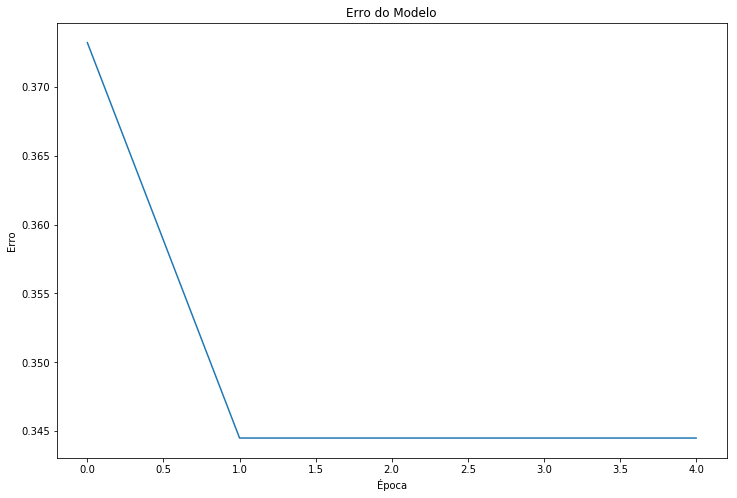

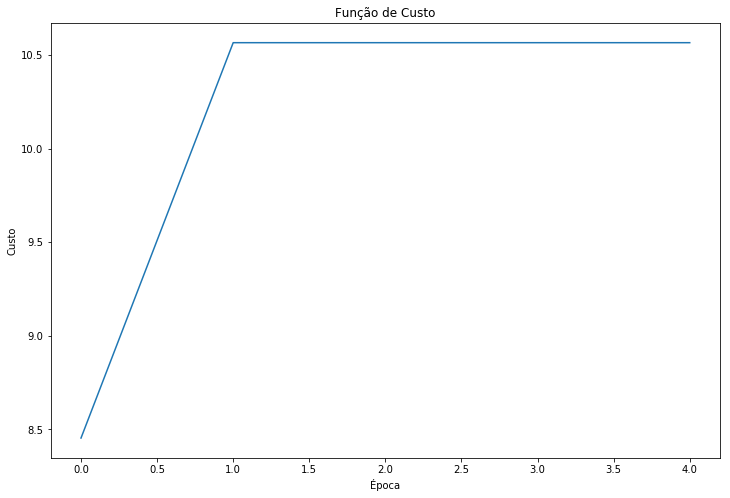

In [7]:
scores = fnn.evaluate(X_test, Y_test, verbose=0)
print("Erro Médio: %.2f%%" % (100-scores[1]*100))

plt.figure(figsize=(12,8))

plt.plot(history.history['acc'])
plt.title('Erro do Modelo')
plt.ylabel('Erro')
plt.xlabel('Época')

plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.title('Função de Custo')
plt.ylabel('Custo')
plt.xlabel('Época')


# Rede Convolucional

In [8]:
cnn = Sequential()
cnn.add(Convolution2D(batch_input_shape=(None, LARGURA, ALTURA, CANAIS), filters=32, kernel_size=5, strides=1, padding='same', data_format='channels_first',))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Convolution2D(15, (3,3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.2))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(50, activation='relu'))
cnn.add(Dense(num_classes, activation='softmax'))
#cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [9]:
X_train = train_set_x_orig
X_test = test_set_x_orig

X_train = X_train.reshape(X_train.shape[0], LARGURA, ALTURA, CANAIS).astype('float32')
X_test = X_test.reshape(X_test.shape[0], LARGURA, ALTURA, CANAIS).astype('float32')

# Normalizando a entrada
X_train = X_train / 255
X_test = X_test / 255

#codificando as saidas
Y_train = np_utils.to_categorical(train_set_y_orig)
Y_test = np_utils.to_categorical(test_set_y_orig)

In [10]:
#criando o callback para salvar o melhor modelo
checkpoint = ModelCheckpoint('weights.best.hdf5', monitor='val_acc', save_best_only=True, mode='max')
callback_list = [checkpoint]

history = cnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=75, batch_size=100, verbose=0, callbacks=callback_list)
print("Terminou")

Terminou


Avaliando o modelo. Primeiro vamos carregar o molhoir modelo (com maior acerto)

Baseline Error: 14.00%


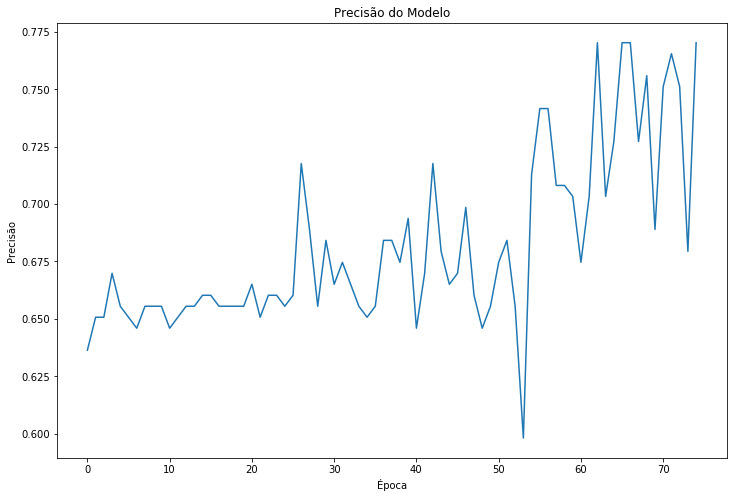

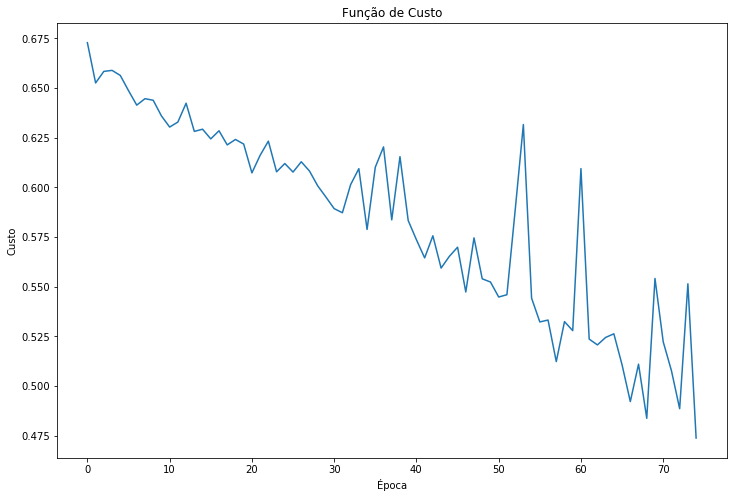

In [11]:
cnn.load_weights("weights.best.hdf5")
cnn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

scores = cnn.evaluate(X_test, Y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

plt.figure(figsize=(12,8))

plt.plot(history.history['acc'])
plt.title('Precisão do Modelo')
plt.ylabel('Precisão')
plt.xlabel('Época')

plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.title('Função de Custo')
plt.ylabel('Custo')
plt.xlabel('Época')

As redes convolucionais se mostraram muitos mais acertivas para o exemplo. 
A rede Feed Forward simples encontrar seus parâmetros já na primeira época e não aprende mais nada de novo nas épocas
subsequentes, equanto a rede convolucional continua aprendendo, de maneira mais errática, mas 
consegue um reultado bem melhor no final